In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
# from pydub import AudioSegment
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import random

from glob import glob # to list all files to a directory
import IPython
import IPython.display as ipd # to play the Audio Files

import librosa # main package for working with Audio Data
import librosa.display
import os
from time import time
from scipy.io import wavfile as wav

from tensorflow import keras
import tarfile
from shutil import copyfile

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Frequency analysis
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow

import warnings
warnings.filterwarnings("ignore")

In [25]:
import soundfile as sf
import shutil

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We want to split the audio signals from 30seconds to 5 seconds files, storing them in the gtzan_train and gtzan_validation folder. 
In this way, we create new mfcc for gtzan_validation.
gtzan_train, instead, will be augmented through **white noise**. Mfcc will be then created and stored in a new folder. 

These 2 folders of mfcc for train and val, based on 5 sec audio, will feed the CNN.


##### Audio train 5 seconds splitting
719 x 6 = 4314 files

In [ ]:
train_folder = '/content/drive/MyDrive/Second year/DSIM_project/gtzan_train'

In [ ]:
len(os.listdir(train_folder))

719

In [ ]:
output_folder = '/content/drive/MyDrive/Second year/DSIM_project/gtzan_train_5sec'

In [ ]:
sr, sd = wav.read('/content/drive/MyDrive/Second year/DSIM_project/gtzan_train/blues.00000.wav')

In [ ]:
segments = int(len(sd) / 6) 

In [ ]:
segments

110299

In [ ]:
len(sd[1:segments])/sr #5 secondi

5.0021768707483

In [ ]:
ipd.Audio(sd[1:segments], rate=sr)

In [ ]:
os.listdir(train_folder)[0][-4]

In [ ]:
for song in os.listdir(train_folder):
  song_path = os.path.join(train_folder, song)
  sr, sd = wav.read(song_path)
  segment_length = int(len(sd)/6) #intervalli di 5 secondi

  if not os.path.exists(output_folder):
    os.makedirs(output_folder)

  for i in range(6):
    start = i * segment_length
    end = (i + 1) * segment_length
    segment = sd[start:end]
    new_filename = f'{song[:-4]}_{i}.wav'
    new_file_path = os.path.join(output_folder, new_filename)
    sf.write(new_file_path, segment, sr)


In [ ]:
len(os.listdir(output_folder)) #train 

4314

##### Audio splitting for validation

In [ ]:
train_folder = '/content/drive/MyDrive/Second year/DSIM_project/gtzan_validation'

In [ ]:
len(os.listdir(train_folder))

180

In [ ]:
voutput_folder = '/content/drive/MyDrive/Second year/DSIM_project/gtzan_val_5sec'

In [ ]:
for song in os.listdir(train_folder):
  song_path = os.path.join(train_folder, song)
  sr, sd = wav.read(song_path)
  segment_length = int(len(sd)/6) #intervalli di 3 secondi

  if not os.path.exists(voutput_folder):
    os.makedirs(voutput_folder)

  for i in range(6):
    start = i * segment_length
    end = (i + 1) * segment_length
    segment = sd[start:end]
    new_filename = f'{song[:-4]}_{i}.wav'
    new_file_path = os.path.join(voutput_folder, new_filename)
    sf.write(new_file_path, segment, sr)


In [ ]:
len(os.listdir(voutput_folder))

1080

##### Data augmentation:  **white noise** addition to 30% of randomly selected 5 seconds audio from train set

In [ ]:
import os
import random
import numpy as np
from scipy.io import wavfile

src_folder = "/content/drive/MyDrive/Second year/DSIM_project/gtzan_train_5sec"
dst_folder = "/content/drive/MyDrive/Second year/DSIM_project/gtzan_train_5sec_wn"

if not os.path.exists(dst_folder):
  os.makedirs(dst_folder)

file_list = os.listdir(src_folder)
random.seed(0)
random.shuffle(file_list)

noise_factor = 0.3
for i, filename in enumerate(file_list):
  if i < len(file_list) * 0.3:
    rate, data = wavfile.read(os.path.join(src_folder, filename))
    data = data.astype("float64")
    noise =   noise_factor*np.random.normal(0,1,len(data)) #np.random.randn(*data.shape) * noise_factor
    data_noisy = data + noise
    new_filename = filename[:-4] + "_noise.wav"
    wavfile.write(os.path.join(dst_folder, new_filename), rate, data_noisy.astype("int16"))
  else:
    os.system(f"cp {os.path.join(src_folder, filename)} {os.path.join(dst_folder, filename)}")
  #   wavfile.write(os.path.join(dst_folder, "noisy_" + filename), rate, data_noisy.astype("int16"))
  # else:
  #   os.system(f"cp {os.path.join(src_folder, filename)} {os.path.join(dst_folder, filename)}")


In [ ]:
len(os.listdir('/content/drive/MyDrive/Second year/DSIM_project/gtzan_train_5sec_wn')) #30% of audio with noise

1295

In [ ]:
#add the 5sec original audio to the noisy folder - join all

In [ ]:
src_folder = "/content/drive/MyDrive/Second year/DSIM_project/gtzan_train_5sec"
dst_folder = "/content/drive/MyDrive/Second year/DSIM_project/gtzan_train_5sec_wn"

if not os.path.exists(dst_folder):
  os.makedirs(dst_folder)

for filename in os.listdir(src_folder):
  src_file = os.path.join(src_folder, filename)
  dst_file = os.path.join(dst_folder, filename)
  shutil.copy2(src_file, dst_file)


In [ ]:
len(os.listdir('/content/drive/MyDrive/Second year/DSIM_project/gtzan_train_5sec_wn')) #30% of audio with noise + all 5 sec original audio

5609

The train set, now consist of 5609 audio files, 5 seconds long.

Creation of MFCC spectrograms for train, storing the result in 'mfcc_train_3sec_wn' folder: 

In [ ]:
def create_mfcc_spectrogram(gtzan, mfcc_images):
    if not os.path.exists(mfcc_images):
        os.makedirs(mfcc_images) 

    for file in os.listdir(gtzan):
        file_path = os.path.join(gtzan, file)
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y*1.0, sr=sr)
        label = file.split('.')[0]
        label_dir = os.path.join(mfcc_images, label)

        # plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfccs)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1,
                        wspace=None, hspace=None)

        if not os.path.exists(label_dir):
            os.makedirs(label_dir)

        save_path = os.path.join(label_dir, file.split('.')[1] + ".png")
        plt.savefig(save_path, frameon=False, dpi=100, bbox_inches='tight', pad_inches=0)
        plt.close()

In [ ]:
train_folder = '/content/drive/MyDrive/Second year/DSIM_project/gtzan_train_5sec_wn'

In [ ]:
mfcc_train_aug = '/content/drive/MyDrive/Second year/DSIM_project/mfcc_train_5sec_wn' #path for augmented train folder 

In [ ]:
create_mfcc_spectrogram(train_folder, mfcc_train_aug)  #create mfcc for train set

Mfccs for validation 

In [ ]:
val_folder = '/content/drive/MyDrive/Second year/DSIM_project/gtzan_val_5sec'

In [ ]:
mfcc_val_5sec = '/content/drive/MyDrive/Second year/DSIM_project/mfcc_val_5sec'

In [ ]:
create_mfcc_spectrogram(val_folder, mfcc_val_5sec)  #create mfcc for train set

#### CNN - Adam optimizer

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
base_path = '/content/drive/MyDrive/Second year/DSIM_project/'

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255.)

In [ ]:
train_dataset = train_gen.flow_from_directory(base_path+'mfcc_train_5sec_wn',
                                                            target_size=(224,224),
                                                            batch_size=128,
                                                            class_mode='categorical',
                                                            shuffle=True,
                                                            seed=1)

Found 5609 images belonging to 10 classes.


In [ ]:
val_gen = ImageDataGenerator(rescale=1./255.)

In [ ]:
val_dataset = val_gen.flow_from_directory(base_path+'mfcc_val_5sec',
                                                            target_size=(224,224),
                                                            batch_size=128,
                                                            class_mode='categorical',
                                                            shuffle=True, #not needed
                                                            seed=1)

Found 1080 images belonging to 10 classes.


In [ ]:
num_classes = 10

### CNN 

In [ ]:
  X_input = keras.Input((224,224,3))

  X = keras.layers.Conv2D(8,kernel_size=(3,3),strides=(1,1))(X_input)
  X = keras.layers.BatchNormalization(axis=3)(X)
  X = keras.layers.Activation('relu')(X)
  X = keras.layers.MaxPooling2D((2,2))(X)
  
  X = keras.layers.Conv2D(16,kernel_size=(3,3),strides = (1,1))(X)
  X = keras.layers.BatchNormalization(axis=3)(X)
  X = keras.layers.Activation('relu')(X)
  X = keras.layers.MaxPooling2D((2,2))(X)
  
  X = keras.layers.Conv2D(32,kernel_size=(3,3),strides = (1,1))(X)
  X = keras.layers.BatchNormalization(axis=3)(X)
  X = keras.layers.Activation('relu')(X)
  X = keras.layers.MaxPooling2D((2,2))(X)

  X = keras.layers.Conv2D(64,kernel_size=(3,3),strides=(1,1))(X)
  X = keras.layers.BatchNormalization(axis=-1)(X)
  X = keras.layers.Activation('relu')(X)
  X = keras.layers.MaxPooling2D((2,2))(X)
  
  X = keras.layers.Conv2D(128,kernel_size=(3,3),strides=(1,1))(X)
  X = keras.layers.BatchNormalization(axis=-1)(X)
  X = keras.layers.Activation('relu')(X)
  X = keras.layers.MaxPooling2D((2,2))(X)

  
  X = keras.layers.Flatten()(X)
  

  X_out = keras.layers.Dense(num_classes, activation='softmax', name='fc' + str(num_classes))(X)

  net = keras.Model(X_input, X_out)

  callback= keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

 

In [ ]:
net.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 222, 222, 8)       224       
                                                                 
 batch_normalization_10 (Bat  (None, 222, 222, 8)      32        
 chNormalization)                                                
                                                                 
 activation_13 (Activation)  (None, 222, 222, 8)       0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 109, 109, 16)      1168

In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=OPTIMIZER,
            metrics= METRICS) 

In [ ]:
history = net.fit(train_dataset, epochs=50,  validation_data=val_dataset) 

Epoch 1/50
44/44 [==============================] - 1798s 41s/step - loss: 1.6690 - accuracy: 0.4045 - precision: 0.6554 - recall: 0.1831 - auc: 0.8325 - top 3 accuracy: 0.7231 - val_loss: 2.4611 - val_accuracy: 0.1000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5078 - val_top 3 accuracy: 0.3000
Epoch 2/50
44/44 [==============================] - 346s 8s/step - loss: 1.2129 - accuracy: 0.5696 - precision: 0.7526 - recall: 0.3546 - auc: 0.9173 - top 3 accuracy: 0.8615 - val_loss: 2.7825 - val_accuracy: 0.1037 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5046 - val_top 3 accuracy: 0.3000
Epoch 3/50
44/44 [==============================] - 335s 8s/step - loss: 0.9899 - accuracy: 0.6557 - precision: 0.8281 - recall: 0.4799 - auc: 0.9464 - top 3 accuracy: 0.9030 - val_loss: 3.0637 - val_accuracy: 0.1019 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5082 - val_top 3 accuracy: 0.3000
Epoch 4/50
44/44 [=============================

In [ ]:
net.save('/content/drive/MyDrive/Second year/DSIM_project/modelli/cnnaug3.h5')

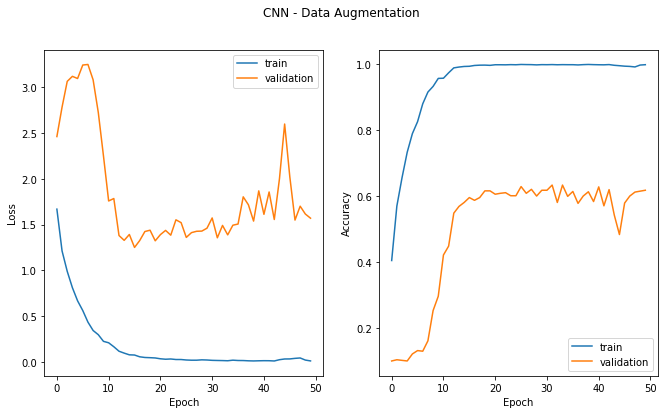

In [ ]:
plt.figure(figsize=(11,6))
plt.suptitle('CNN - Data Augmentation')
# Visualization of the learning curves
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])
plt.savefig('/content/drive/MyDrive/Second year/DSIM_project/modelli/plotaug_cnn3.jpg')

Accuracy of 62%. Top 3 accuracy: 87%. 

### Test

In [27]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
# Image management
from skimage import io # Input/output
from skimage import transform # Geometric transformations (e.g. resize)
from skimage import filters # Local processing
from skimage import color # Change of color space
# Keras modules
from tensorflow import keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import mobilenet_v2
from keras.preprocessing.image import ImageDataGenerator

In [28]:
test_folder = '/content/drive/MyDrive/Second year/DSIM_project/gtzan_test'

In [29]:
base_path = '/content/drive/MyDrive/Second year/DSIM_project/'

#### Preprocessing to test audio

In [ ]:
#Split in 5 seconds

In [ ]:
toutput_folder = '/content/drive/MyDrive/Second year/DSIM_project/gtzan_test_5sec'

In [ ]:
for song in os.listdir(test_folder):
  song_path = os.path.join(test_folder, song)
  sr, sd = wav.read(song_path)
  segment_length = int(len(sd)/6) #intervalli di 3 secondi

  if not os.path.exists(toutput_folder):
    os.makedirs(toutput_folder)

  for i in range(6):
    start = i * segment_length
    end = (i + 1) * segment_length
    segment = sd[start:end]
    new_filename = f'{song[:-4]}_{i}.wav'
    new_file_path = os.path.join(toutput_folder, new_filename)
    sf.write(new_file_path, segment, sr)

In [ ]:
### mfccspectrograms for test splitted in 5 seconds

In [ ]:
mfcc_test =  '/content/drive/MyDrive/Second year/DSIM_project/mfcc_test'

In [ ]:
create_mfcc_spectrogram(toutput_folder,mfcc_test)

#### Test set evaluation

In [30]:
classi = '/content/drive/MyDrive/Second year/DSIM_project/mfcc_test'

In [31]:
class_labels = [d for d in os.listdir(classi)]

In [32]:
class_labels

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [34]:
cnn = keras.models.load_model('/content/drive/MyDrive/Second year/DSIM_project/modelli/cnnaug3.h5')

In [35]:
test_gen = ImageDataGenerator(rescale=1./255.)

In [36]:
test_dataset = test_gen.flow_from_directory(base_path+'mfcc_test',
                                                            target_size=(224,224),
                                                            batch_size=128,
                                                            class_mode='categorical',
                                                            shuffle=False,
                                                            seed=1) 
                                          #  classes = class_labels)
                                                          

Found 600 images belonging to 10 classes.


In [37]:
eval = cnn.evaluate(test_dataset)

5/5 [==============================] - 145s 36s/step - loss: 1.4960 - accuracy: 0.6267 - precision: 0.6562 - recall: 0.5917 - auc: 0.9113 - top 3 accuracy: 0.8833


In [38]:
print("Test Loss:", eval[0])

Test Loss: 1.4960460662841797


In [39]:
print("Test Accuracy:", eval[1])

Test Accuracy: 0.6266666650772095


In [40]:
# Inference
yc_pred = cnn.predict(test_dataset)
print('Prediction shape (probability distribution):', yc_pred.shape)

5/5 [==============================] - 4s 672ms/step
Prediction shape (probability distribution): (600, 10)


In [41]:
# Selection of the highest-probability class for each test sample
y_pred = np.argmax(yc_pred, axis=1)
print('Prediction shape (argmax):', y_pred.shape)

Prediction shape (argmax): (600,)


In [42]:
y_test = test_dataset.classes #retrieve ground truth

In [43]:
# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        60
           1       0.89      0.90      0.89        60
           2       0.71      0.53      0.61        60
           3       0.41      0.67      0.51        60
           4       0.54      0.50      0.52        60
           5       0.57      0.72      0.64        60
           6       0.93      0.88      0.91        60
           7       0.54      0.72      0.62        60
           8       0.85      0.28      0.42        60
           9       0.51      0.37      0.43        60

    accuracy                           0.63       600
   macro avg       0.66      0.63      0.62       600
weighted avg       0.66      0.63      0.62       600



Confusion matrix:


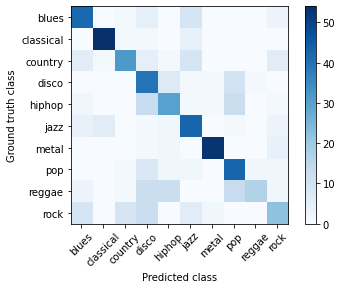

In [44]:
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.yticks(range(len(class_labels)), class_labels)
plt.colorbar()

#### Demo

Consider a blues song (blues.00008 audio track)

In [45]:
sound_rate, sound_data = wav.read('/content/drive/MyDrive/Second year/DSIM_project/gtzan_test/blues.00008.wav')
# Play the signal
ipd.Audio(sound_data, rate= sound_rate)

example: the mfcc spectrogram for the 1st segment of 5 seconds

In [46]:
img = kimage.load_img('/content/drive/MyDrive/Second year/DSIM_project/mfcc_test/blues/00008_0.png', target_size=(224, 224))
type(img)

PIL.Image.Image

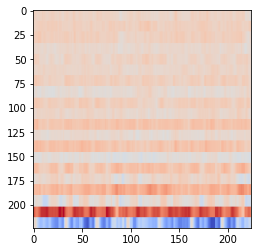

In [47]:
plt.imshow(img); plt.show()

In [48]:
os.listdir('/content/drive/MyDrive/Second year/DSIM_project/mfcc_test')

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [49]:
#function to extract genre from mfcc image
def predict_file(path):
  img = kimage.load_img(path, target_size=(224, 224))
  x = kimage.img_to_array(img)
  x = x.astype('float32')
  x /=255.0
  x = np.expand_dims(x, axis=0)
  yc_pred = cnn.predict(x)
  m, n = yc_pred.shape
  file_names = os.listdir('/content/drive/MyDrive/Second year/DSIM_project/mfcc_test')
  indices = np.argpartition(-yc_pred, 3, axis=1)[:, :3]
  probs = np.sort(-yc_pred, axis=1)[:, :3]
  df = pd.DataFrame({'Index': indices.flatten(), 'Probability': -probs.flatten()})
  df['File Name'] = [file_names[index] for index in indices.flatten()]
  df.columns = ['Index', 'Probability', 'Genre']
  return df

Predict for each 5 second segment, the genre of the song

In [50]:
#segment 1
predict_file('/content/drive/MyDrive/Second year/DSIM_project/mfcc_test/blues/00008_0.png')

1/1 [==============================] - 0s 244ms/step


,Index,Probability,Genre
0,0,0.733714,blues
1,4,0.118467,hiphop
2,2,0.090323,country


In [51]:
#segment 2
predict_file('/content/drive/MyDrive/Second year/DSIM_project/mfcc_test/blues/00008_1.png')


1/1 [==============================] - 0s 20ms/step


,Index,Probability,Genre
0,3,0.607905,disco
1,0,0.232906,blues
2,2,0.085625,country


In [52]:
#segment 3
predict_file('/content/drive/MyDrive/Second year/DSIM_project/mfcc_test/blues/00008_2.png')

1/1 [==============================] - 0s 21ms/step


,Index,Probability,Genre
0,0,0.967822,blues
1,9,0.016397,rock
2,2,0.011934,country


In [53]:
#segment 4
predict_file('/content/drive/MyDrive/Second year/DSIM_project/mfcc_test/blues/00008_3.png')

1/1 [==============================] - 0s 21ms/step


,Index,Probability,Genre
0,0,0.382394,blues
1,4,0.318154,hiphop
2,2,0.104593,country


In [54]:
#segment 5
predict_file('/content/drive/MyDrive/Second year/DSIM_project/mfcc_test/blues/00008_4.png')

1/1 [==============================] - 0s 22ms/step


,Index,Probability,Genre
0,3,0.930740,disco
1,0,0.053135,blues
2,2,0.008810,country


In [55]:
#segment 6
predict_file('/content/drive/MyDrive/Second year/DSIM_project/mfcc_test/blues/00008_5.png')

1/1 [==============================] - 0s 19ms/step


,Index,Probability,Genre
0,2,0.336894,country
1,0,0.200563,blues
2,9,0.178875,rock


As we can see, considering the top 1 accuracy, the correct genre 'blues' appears 3 times out of 6, leading to a 50% accuracy.
Considering the top 2 accuracy, it appears 6/6, leading to a 100%. The same hold for top 3 accuracy. 

#### Evaluation - downloaded song from youtube

Input an external song, downloaded from internet, in the wav format. 

Predict its genre, based on 5 second segment randomly extracted.

Most of the times, the expected genre is in the top 3 predictions.

In [56]:
mfcc_path = "/content/drive/MyDrive/Second year/DSIM_project/mfcc_canzoni_nostre"

In [57]:
def predict_genre(file_path, mfcc_path = mfcc_path): #file wav canzone nuova
    # Load the original wav file
    audio, sr = sf.read(file_path)

    # Get the length of the audio file in samples
    length = audio.shape[0]

    # Generate a random start sample for the 5 second segment
    start = random.randint(0, length - sr * 5)

    # Extract the 5 second segment from the original file
    segment = audio[start:start + sr * 5, 0]

    # Get the name and path of the original file
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    file_ext = os.path.splitext(os.path.basename(file_path))[1]
    file_folder = os.path.dirname(file_path)

    # Create the name for the new file
    new_file_name = f"{file_folder}/{'5sec_'}{file_name}{file_ext}"

    # Save the segment to a new wav file
    sf.write(new_file_name, segment, sr)

    # Generate the MFCC spectrogram and save it in mfcc_path
    mfccs = librosa.feature.mfcc(y=segment*1.0, sr=sr)
    mfcc_file_name = f"{'5sec_'}{file_name}.png"
    mfcc_file_path = os.path.join(mfcc_path, mfcc_file_name)
    librosa.display.specshow(mfccs)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1,
                        wspace=None, hspace=None)
    plt.savefig(mfcc_file_path, frameon=False, dpi=100, bbox_inches='tight', pad_inches=0)
    plt.close()

    img = kimage.load_img(mfcc_file_path, target_size=(224, 224))
    x = kimage.img_to_array(img)
    x = x.astype('float32')
    x /=255.0
    x = np.expand_dims(x, axis=0)
    yc_pred = cnn.predict(x)
    m, n = yc_pred.shape
    file_names = os.listdir('/content/drive/MyDrive/Second year/DSIM_project/mfcc_test')
    indices = np.argpartition(-yc_pred, 3, axis=1)[:, :3]
    probs = np.sort(-yc_pred, axis=1)[:, :3]
    df = pd.DataFrame({'Index': indices.flatten(), 'Probability': -probs.flatten()})
    df['File Name'] = [file_names[index] for index in indices.flatten()]
    df.columns = ['Index', 'Probability', 'Genre']
    return df




**Nirvana - Smells like teen spirit**

Expected Genre: Rock

In [60]:
predict_genre("/content/drive/MyDrive/Second year/DSIM_project/canzoni_nostre/Nirvana.wav")

1/1 [==============================] - 0s 21ms/step


,Index,Probability,Genre
0,9,0.644561,rock
1,4,0.244097,hiphop
2,0,0.088095,blues


**Mozart - Lacrimosa**

Expected genre: Classical

In [64]:
predict_genre("/content/drive/MyDrive/Second year/DSIM_project/canzoni_nostre/Mozart.wav")

1/1 [==============================] - 0s 21ms/step


,Index,Probability,Genre
0,7,0.847386,pop
1,1,0.140896,classical
2,2,0.004208,country
